<a href="https://colab.research.google.com/github/roshantac/EVA4/blob/master/Assignment15/B/BothFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!nvidia-smi

['Fri May 22 05:19:03 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   53C    P0    44W / 250W |      0MiB / 16280MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

In [0]:
 %matplotlib inline

In [0]:
!pip install kornia
from kornia.losses import SSIM

In [12]:
!git clone https://github.com/roshantac/Unet.git

Cloning into 'Unet'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 59 (delta 24), reused 40 (delta 13), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [0]:
!mkdir Unet/data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir Dataset
!cp '/content/drive/My Drive/Rohit dataset/Dataset.zip' Dataset


In [0]:
destDataDir = '/content/Dataset/'
path_to_zip_file = '/content/Dataset/Dataset.zip'
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(destDataDir)

In [1]:
%cd Unet/

/content/Unet


In [0]:
pwd

'/content/Unet'

In [0]:
import argparse
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from eval import eval_net
from unet import UNet
from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

In [0]:
root = '/content/'
def getData(root,batch_size ,val_percent):
    dataset = BasicDataset(root)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
    return train_loader,val_loader

trainLoader, testLoader = getData(root,32,0.9)

In [0]:
import torchvision
import matplotlib.pyplot as plt

def show(tensors, figsize= (10,10), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
  tensors = (tensors * std[None, : , None, None]) + mean[None, :, None, None]
  show(tensors, *args, **kwargs)

In [0]:
sample = next(iter(testLoader))

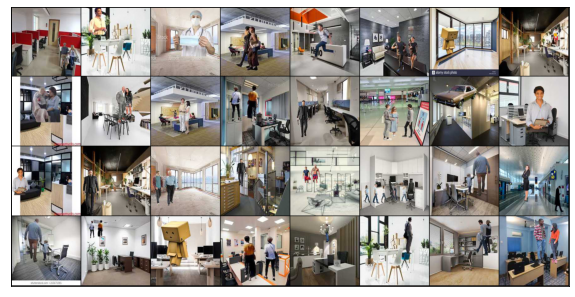

In [8]:
show(sample['fgbg'], nrow=8)

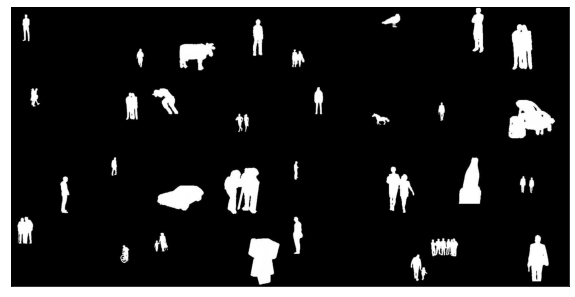

In [8]:
show(sample['mask'],nrow=8)

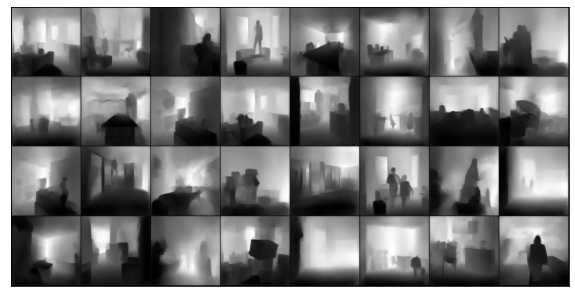

In [9]:
show(sample['depth'],nrow=8)

In [0]:
def draw_and_save(tensors, name, figsize=(20,20),*args,**kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.savefig(name,bbox_inches='tight')
  plt.close()

In [0]:
def train_net(net, device,train_loader, epochs , lr ):
    import datetime
    global_step = 0
    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)
    criterion = nn.BCEWithLogitsLoss()
    #criterion = SSIM(kernel_size, reduction = 'mean)
    n_train =len(train_loader)
    init = datetime.datetime.now()
    for epoch in range(epochs):
        start =  datetime.datetime.now()
        net.train()
        epoch_loss = 0  
        pbar = tqdm(train_loader)
        #with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:

        for i,batch in enumerate(pbar):
            batch['bg'] = batch['bg'].to(device, dtype = torch.float32)
            batch['fgbg'] = batch['fgbg'].to(device, dtype = torch.float32)
            batch['mask'] = batch['mask'].to(device, dtype = torch.float32)
            batch['depth'] = batch['depth'].to(device, dtype = torch.float32) 
            #depth_pred, masks_pred
            output = net(batch)
            loss1 = criterion(output[1], batch['mask'])
            loss2 = criterion(output[0], batch['depth']) 
            loss = 2*loss1 + loss2 
            epoch_loss += loss.item()
            pbar.set_postfix(desc  = f'Epoch : {epoch+1}  Loss : {loss.item()}  l1: {loss1.item()} l2 = {loss2.item()}')
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
        scheduler.step() #loss
        end=  datetime.datetime.now()
        print("Time taken for epoch is: ", end-start)
        print(" Total time taken is : ", end -init)
        print("ground truth")
        show(batch['Depth'].detach().cpu(),nrow=8)
        print("Depth")
        show(output[0].detach().cpu(),nrow=8) # depth
        print("mask")
        show(output[1].detach().cpu(),nrow=8) #mask


In [9]:

net = UNet(n_channels=6, n_classes=1, bilinear=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


UNet(
  (inc_m): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1_m): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentu

In [0]:
logging.info(f'Using device {device}')
net =torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark=True
# Train
train_net(net,device, trainLoader, 5, 0.01)

 20%|██        | 256/1250 [01:51<06:47,  2.44it/s, desc=Epoch : 1  Loss : 0.6570033431053162  l1: 0.034641750156879425 l2 = 0.5877198576927185]

In [0]:
del net

In [0]:
!cp checkpoints/*.pth '/content/drive/My Drive/Untitled folder/'

cp: target '/content/drive/My Drive/Untitled folder/' is not a directory


In [0]:
class ConvGen(nn.Module):
  '''Generator'''
  def __init__(self):
    super(ConvGen,self).__init__()

    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1, 
                                              padding=1, bias= False),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False,groups=32),
                                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,1),stride=1,
                                              padding=0,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=3,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=1,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))    

  def forward(self,sample):
    f1 = sample['bg']    
    f2 = sample['fgbg']
    g1 = f1
    g2 =f2

    f1 = self.convblock2(self.convblock1(f1))
    f2 = self.convblock2(self.convblock1(f2))

    g1 = self.convblock2(self.convblock1(g1))
    g2 = self.convblock2(self.convblock1(g2))
    g = torch.cat([g1,g2],dim=1)
    f = torch.cat([f1,f2], dim=1)
    h = self.convblock5(self.convblock4(self.convblock3(f)))
    i =self.convblock5(self.convblock4(self.convblock3(g)))

    return h,i

In [0]:
#criterion = SSIM(kernel_size, reduction = 'mean)
criterion = nn.BCEWithLogitsLoss()

In [12]:
!pip install kornia
from kornia.losses import SSIM

In [9]:
model    = ConvGen()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

ConvGen(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )

In [0]:
optim = torch.optim.SGD(model.parameters(),lr=0.01, momentum = 0.9, weight_decay = 1e-5)

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  import time
  for batch_idx, data in enumerate(train_loader):
    data['bg'] = data['bg'].to(device, dtype = torch.float32)
    data['fgbg'] = data['fgbg'].to(device, dtype = torch.float32)
    data['mask'] = data['mask'].to(device, dtype = torch.float32)
    data['depth'] = data['depth'].to(device, dtype = torch.float32)

    optimizer.zero_grad()
    output1, output2 = model(data)

 # breakpoint()

    loss1 = criterion(output1, data['mask'])
    loss2 = criterion(output2,data['depth'])   
    loss = loss1+2*loss2
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
     
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      print('Batch ID:', batch_idx)

    if batch_idx % 500 == 0:
      #show_pred(output.detach().cpu(), nrow =2) # nrow = sqrt-bs
  
      show(output1.detach().cpu(),nrow = 8)   # nrow = sqrt-bs
      show(output2.detach().cpu(),nrow = 8)

In [0]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size =1, gamma = 0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [0/40000 (0%)]	Loss: 1.077178
Batch ID: 0


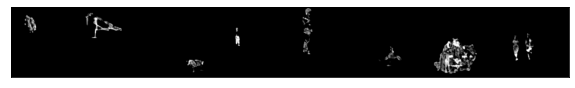

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


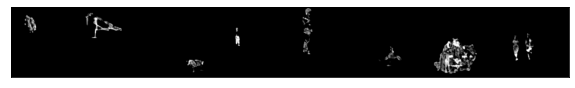

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [2000/40000 (10%)]	Loss: 1.113135
Batch ID: 500


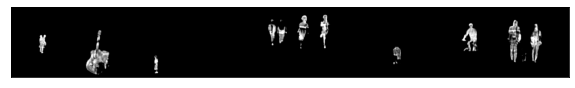

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


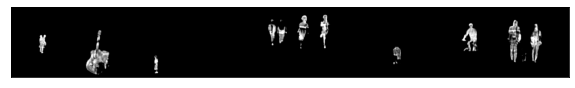

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [4000/40000 (20%)]	Loss: 1.077955
Batch ID: 1000


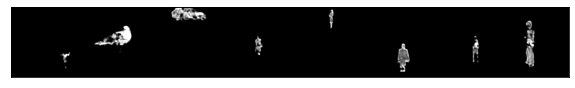

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


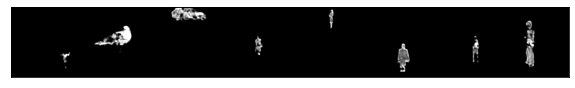

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [6000/40000 (30%)]	Loss: 1.025777
Batch ID: 1500


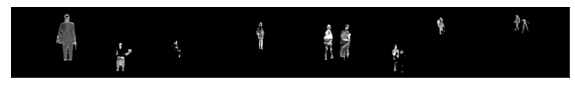

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


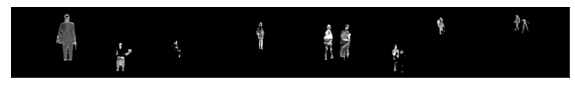

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [8000/40000 (40%)]	Loss: 1.077130
Batch ID: 2000


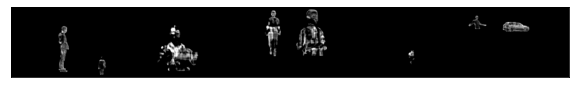

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


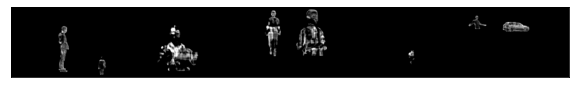

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [10000/40000 (50%)]	Loss: 1.067806
Batch ID: 2500


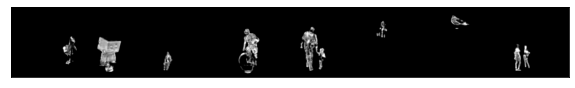

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


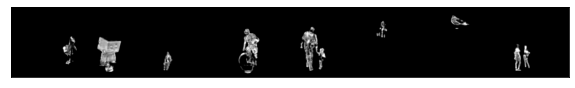

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [12000/40000 (60%)]	Loss: 1.072065
Batch ID: 3000


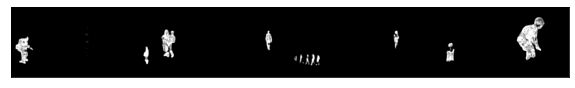

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


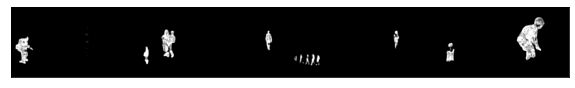

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [14000/40000 (70%)]	Loss: 1.053293
Batch ID: 3500


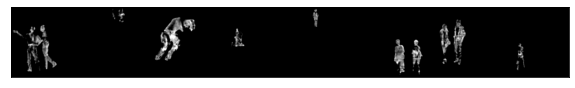

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


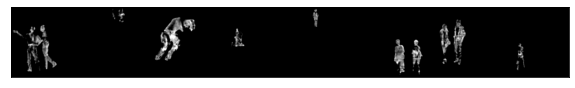

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [16000/40000 (80%)]	Loss: 1.028560
Batch ID: 4000


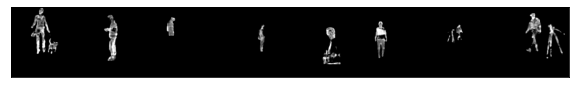

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


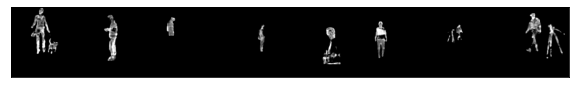

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [18000/40000 (90%)]	Loss: 0.992792
Batch ID: 4500


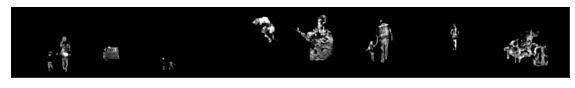

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


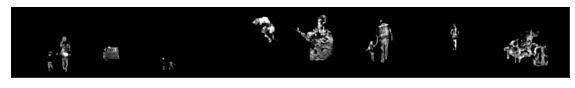

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/40000 (0%)]	Loss: 1.065002
Batch ID: 0


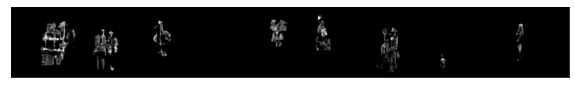

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


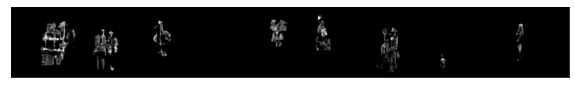

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2000/40000 (10%)]	Loss: 1.058114
Batch ID: 500


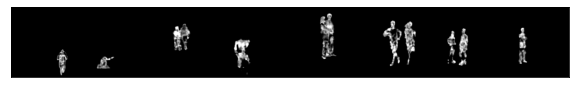

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


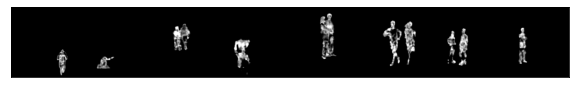

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4000/40000 (20%)]	Loss: 0.982643
Batch ID: 1000


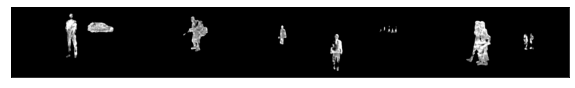

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


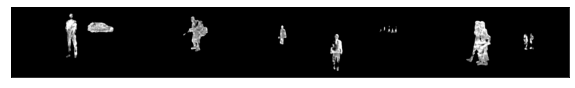

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6000/40000 (30%)]	Loss: 1.056408
Batch ID: 1500


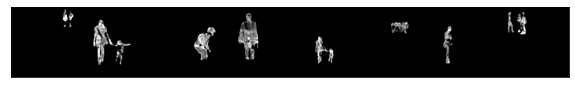

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


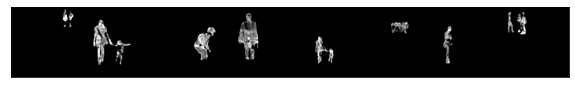

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [8000/40000 (40%)]	Loss: 0.999797
Batch ID: 2000


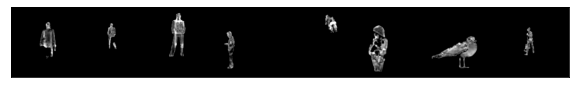

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


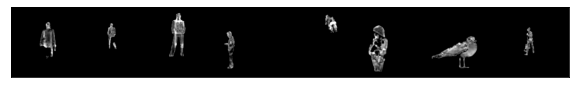

KeyboardInterrupt: ignored

In [23]:
for epoch in range(0,6):
  train(model, criterion, model.device, trainLoader, optim, epoch)
  #test(model, device, test_loader)
  scheduler.step()

In [0]:
# predict
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset


def predict_img2(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        depth, mask = net(img) #depth, mask

        if net.n_classes > 1:
            probs1 = F.softmax(depth, dim=1)
        else:
            probs1 = torch.sigmoid(depth)
            ############2
        if net.n_classes > 1:
            probs2 = F.softmax(mask, dim=1)
        else:
            probs2 = torch.sigmoid(mask)

        probs1 = probs1.squeeze(0)

        probs2 = probs2.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs1 = tf(probs1.cpu())
        probs2 = tf(probs2.cpu())
        full_depth = probs1.squeeze().cpu().numpy()
        full_mask = probs2.squeeze().cpu().numpy()
    full_depth = full_depth - np.min(full_depth)
    full_depth = full_depth / np.max(full_depth)
    return full_depth , full_mask #> out_threshold


def get_output_filenames(args):
    in_files = args.input
    out_files = []

    if not args.output:
        for f in in_files:
            pathsplit = os.path.splitext(f)
            out_files.append("{}_OUT{}".format(pathsplit[0], pathsplit[1]))
    elif len(in_files) != len(args.output):
        logging.error("Input files and output files are not of the same length")
        raise SystemExit()
    else:
        out_files = args.output

    return out_files


def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))



In [0]:
!mkdir sample50
!mkdir sample50/out
!mkdir sample50/ind
!mkdir sample50/act
from predict import *
from PIL import Image
sdir = 'sample50/out/'
actdir ='sample50/act/'
indir ='sample50/ind/'
for i,idx in enumerate(os.listdir('data/fgbg/')):
  if i==10:
    break;
  img = Image.open('data/fgbg/'+idx)
  img.save(indir+idx)
  act = Image.open('data/depth/'+idx)
  act.save(actdir+idx)
  depth, mask = predict_img2(net=net, full_img=img, scale_factor=1.0, out_threshold=0.1, device=device)
  result1 = mask_to_image(mask)
  result2 = mask_to_image(depth)
  result1.save(sdir+idx)
  result2.save(sdir+'depth'+idx)


In [0]:
mkdir sample50/out

In [0]:
!cp -r sample50 '/content/drive/My Drive/'

In [0]:
# dataset
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image


class BasicDataset(Dataset):
    def __init__(self, root):
        self.root = root
        data_file = open(root+'Dataset/'+'label_data.csv')
        self.data = data_file.readlines()

    def __len__(self):
        return len(self.data)

    @classmethod
    def preprocess(cls, pil_img):

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
        return img_trans

    def __getitem__(self, i):
        idx = self.data[i].split(';')
        bg = Image.open(self.root + idx[0].replace('"',''))
        fgbg = Image.open(self.root + idx[1].replace('"',''))
        mask = Image.open(self.root + idx[2].replace('"',''))
        depth = Image.open(self.root + idx[3].replace('"','').replace('\n',''))
        bg = self.preprocess(bg)
        fgbg = self.preprocess(fgbg)
        mask = self.preprocess(mask)
        depth =self.preprocess(depth)
        return {'bg' : torch.from_numpy(bg), 'fgbg': torch.from_numpy(fgbg), 'mask': torch.from_numpy(mask), 'depth': torch.from_numpy(depth)}


In [0]:
""" Full assembly of the parts to form the complete network """
#unet_model
import torch.nn.functional as F

from .unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, data):
        dat1 = data['fgbg']
        dat2 = data['bg']
        x = torch.cat([dat1,dat2], dim = 1)
        y = x
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        rt_depth = self.outc(x)

        y1 = self.inc(y) 
        y2 = self.down1(y1) 
        y3 = self.down2(y2)  
        y4 = self.down3(y3) 
        y5 = self.down4(y4) 
        y = self.up1(y5, y4) 
        y = self.up2(y, y3) 
        y = self.up3(y, y2) 
        y = self.up4(y, y1) 
        rt_mask = self.outc(y) 
        return rt_depth, rt_mask 


In [0]:
# predict
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset


def predict_img(net, full_img, device,  out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(full_img))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        dat = enumerate(testLoader).next()
        depth, mask = net(img) #depth, mask
        probs1 = torch.sigmoid(depth)
        probs2 = torch.sigmoid(mask)
        probs1 = probs1.squeeze(0)
        probs2 = probs2.squeeze(0)
        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs1 = tf(probs1.cpu())
        probs2 = tf(probs2.cpu())
        full_depth = probs1.squeeze().cpu().numpy()
        full_mask = probs2.squeeze().cpu().numpy()
    full_depth = full_depth - np.min(full_depth)
    full_depth = full_depth / np.max(full_depth)
    return full_depth , full_mask# > out_threshold


def get_output_filenames(args):
    in_files = args.input
    out_files = []

    if not args.output:
        for f in in_files:
            pathsplit = os.path.splitext(f)
            out_files.append("{}_OUT{}".format(pathsplit[0], pathsplit[1]))
    elif len(in_files) != len(args.output):
        logging.error("Input files and output files are not of the same length")
        raise SystemExit()
    else:
        out_files = args.output

    return out_files


def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))

